# 0. Import

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def ShowImage(image, axis="on", cmap=None):
    plt.axis(axis)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB), cmap=cmap)
    pass

# 0.1 Download


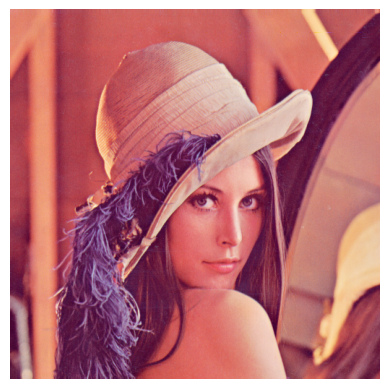

In [2]:
image = cv.imread("lenna.png")
ShowImage(image, "off")

# 1. Face detection

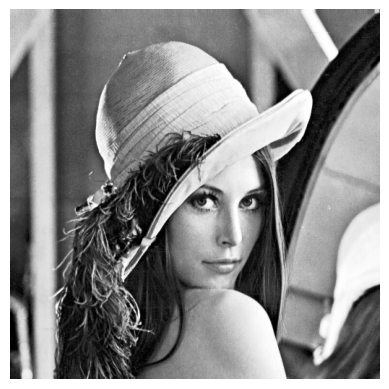

In [3]:
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
gray_image_equalize = cv.equalizeHist(gray_image)
ShowImage(gray_image_equalize, "off", cmap="gray")

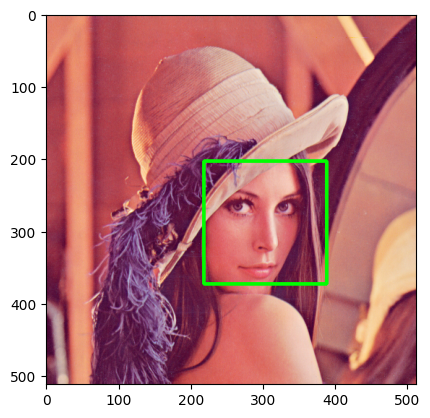

In [4]:
face_cascade = cv.CascadeClassifier("haarcascade_frontalface_default.xml")

faces_rect = face_cascade.detectMultiScale(gray_image_equalize, scaleFactor=1.1, minNeighbors=9)

for (x, y, w, h) in faces_rect:
    cv.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), thickness=3)

ShowImage(image)

# 2. Obtaining the fragment

In [5]:
faces_rect = faces_rect[0]
print(faces_rect)

[218 203 170 170]


In [6]:
x1 = faces_rect[0]
x2 = x1 + faces_rect[2]
y1 = faces_rect[1]
y2 = y1 + faces_rect[3]



In [7]:
print(int(x1 - x1 * 0.1), int(x2 * 1.1), int(y1 - y1 * 0.1), int(y2 * 1.1))

196 426 182 410


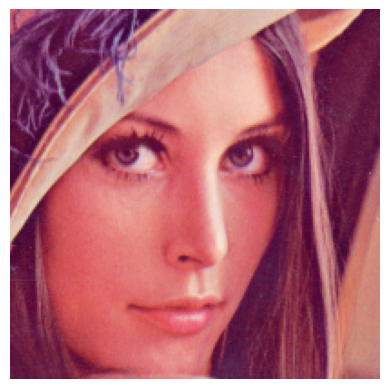

In [8]:
image = cv.imread("lenna.png")

x1 = int(faces_rect[0] - faces_rect[2] * 0.1)
x2 = int(x1 + faces_rect[2] * 1.2)
y1 = int(faces_rect[1] - faces_rect[3] * 0.1)
y2 = int(y1 + faces_rect[3] * 1.2)

face_image = image[y1 : y2, 
                   x1 : x2, 
                   :]

ShowImage(face_image, "off")

# 3. Edge detection

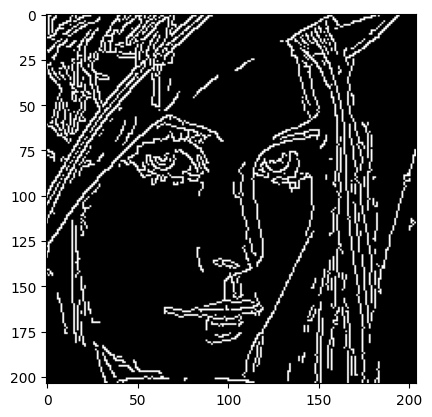

In [9]:
gray_image = cv.cvtColor(face_image, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray_image, 78, 118)
plt.imshow(edges, cmap="gray")
pass

# 4. Corner Points

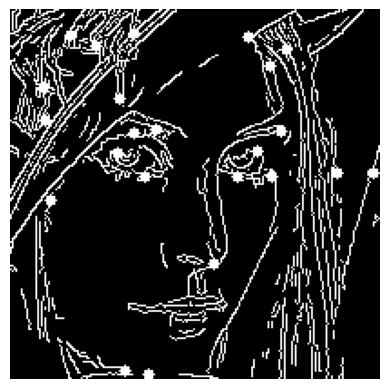

In [10]:
#gray_face_image = cv.cvtColor(face_image,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(edges, 23, 0.01, 10)
corners = np.intp(corners)

for i in corners:
    x, y = i.ravel()
    cv.circle(edges, (x, y), 3, 255, -1)

ShowImage(edges, "off", "gray")

# 5. Dilation

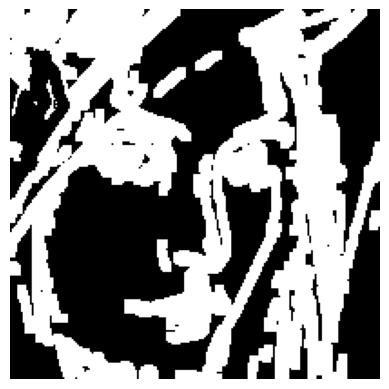

In [11]:
contours, _ = cv.findContours(edges, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
areas = [cv.contourArea(c) for c in contours]
max_index = np.argmax(areas)

kernel = np.ones((5, 5), np.uint8)
edges = cv.dilate(edges, kernel)

cv.drawContours(edges, contours, max_index, (0, 0, 255), 5)

ShowImage(edges, "off", "gray")

# 6. Gaussian blur on edges

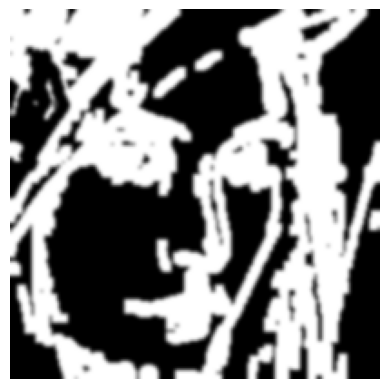

In [12]:
blur_edges = cv.GaussianBlur(edges, (5,5), 0)
ShowImage(blur_edges, "off")

# 7. Normalization

In [13]:
M = cv.normalize(blur_edges.astype('float'), None, 0, 1, cv.NORM_MINMAX)

# 8. Gaussian blur on the face

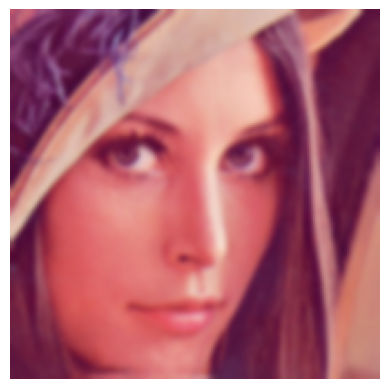

In [14]:
F1 = cv.GaussianBlur(face_image, (7, 7), 0)
ShowImage(F1, "off")

# 9. Converting the image to HSV and increasing saturation

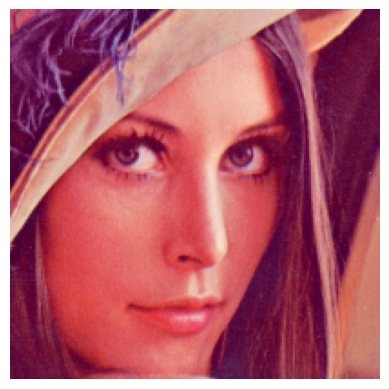

In [15]:
F2 = cv.cvtColor(face_image, cv.COLOR_BGR2HSV)

h, s, v = cv.split(F2)

saturated_s = np.clip(s * 1.15, 0, 255).astype(np.uint8)

F2 = cv.merge([h, saturated_s, v])

F2 = cv.cvtColor(F2, cv.COLOR_HSV2BGR)

ShowImage(F2, "off")

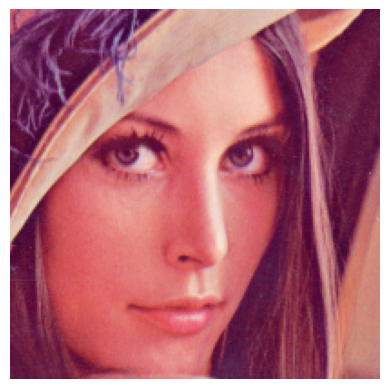

In [16]:
ShowImage(face_image, "off")

# 10. Sharpening

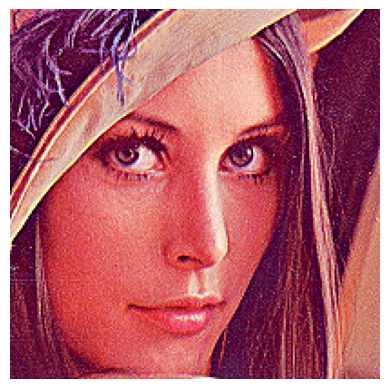

In [17]:
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
F2 = cv.filter2D(F2, -1, kernel)
ShowImage(F2, "off")

# 11. Final Filter

In [18]:
Result = np.zeros(face_image.shape)

for c in range(3):
    for y in range(face_image.shape[1]):
        for x in range(face_image.shape[0]):
            Result[x, y, c] = M[x, y] * F2[x, y, c] + (1 - M[x, y]) * F1[x, y, c]

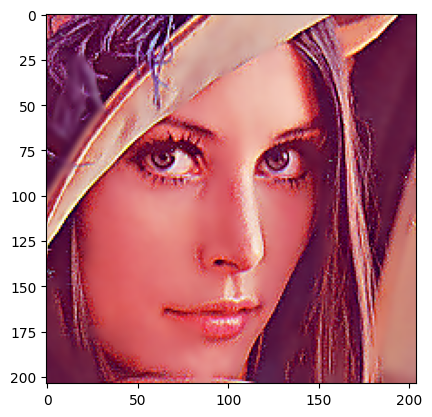

In [19]:
ShowImage(Result.astype(np.uint8))